# ------------------------------------------------------------
# Multi-class
# ------------------------------------------------------------

#### Read

In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import pandas as pd
import tkinter as tk
from tkinter import filedialog

## Select the input file
print('Select the input file\n')
root = tk.Tk()
root.withdraw()
file = filedialog.askopenfilename(filetypes =(("Export Call - CS", "*.xlsx"),("All Files","*.*")))

## Read the file
print('Reading...\n')
export = pd.read_excel(file, index_col='Date Of Test', header=0, decimal=",")
export.index = pd.to_datetime(export.index)

Select the input file

Reading...



#### Discretize MOS and get a "ModelFrame" object

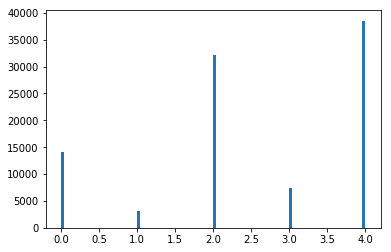

df:  (95466, 8)
df_with_coord:  (95466, 10)


In [15]:
from sklearn.preprocessing import LabelEncoder
import pandas_ml as pdml
import matplotlib.pyplot as plt
import numpy as np



## Select only these columns
df = export.copy()
df = df.filter(items=['Signal (dBm)','Speed (m/s)','Distance from site (m)','Call Test Duration (s)',
                          'Call Test Result','Call Test Technology', 'MANUFACTURER', 'Estimated MoS'])

## Store a variable with LATITUDE and LONGITUDE too
df_with_coord = export.copy()
df_with_coord = df_with_coord.filter(items=['Signal (dBm)','Speed (m/s)','Distance from site (m)','Call Test Duration (s)',
                          'Call Test Result','Call Test Technology', 'MANUFACTURER', 'Estimated MoS','Latitude','Longitude'])

################df = df[(df['Call Test Technology']!='LTE')]    ##########################

# quantize MOS
df.loc[df['Estimated MoS']<=1.0,'Estimated MoS'] = 1.0
for th in [1.0, 2.0, 3.0, 4.0, 5.0]:
     df.loc[(df['Estimated MoS']>th - 1)&(df['Estimated MoS']<=th),'Estimated MoS'] = th
        
#Label encoding
df[['Call Test Result','Call Test Technology',
    'MANUFACTURER', 'Estimated MoS']] = df[['Call Test Result','Call Test Technology','MANUFACTURER', 
                                                    'Estimated MoS']].apply(LabelEncoder().fit_transform)

#################df.drop(inplace=True, labels='Call Test Technology', axis=1)  ###################

#Drop NaN
#df['Signal (dBm)'].fillna(-1, inplace = True)
df.dropna(inplace=True)
df_with_coord.dropna(inplace=True)

#plot MOS
plt.hist(df['Estimated MoS'],100)
plt.show()

print('df: ', df.shape)
print('df_with_coord: ', df_with_coord.shape)

df = pdml.ModelFrame(df, target='Estimated MoS')
df_with_coord = pdml.ModelFrame(df_with_coord, target='Estimated MoS')

#### Over-Sampling (to Handle Imbalanced Dataset)

4    38532
2    32150
0    14156
3     7497
1     3131
Name: Estimated MoS, dtype: int64
4    38532
3    38532
2    38532
1    38532
0    38532
Name: Estimated MoS, dtype: int64


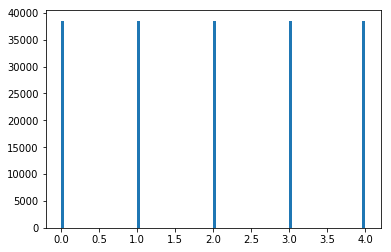

In [3]:
print(df.target.value_counts())

sampler = df.imbalance.over_sampling.SMOTE()
sampled = df.fit_sample(sampler)

print(sampled.target.value_counts())

plt.hist(sampled['Estimated MoS'],100)
plt.show()

#### Train/Test split

In [4]:
from sklearn.model_selection import train_test_split

#Split also the not-sampled dataframe, in order to get an array of predictions
#on the original dataset (this is required because otherwise the "predict()" function throws an error if giving the dataset
#directly as input) --to be updated

X_train_ns, X_test_ns = df.model_selection.train_test_split(random_state=0)
print('Train rows: {0}'.format(X_train_ns.shape[0]))
print('Test rows: {0}'.format(X_test_ns.shape[0]))

df = sampled.copy()    #dtype = ModelFrame
## Define features and target
#X = df[['Signal (dBm)','Speed (m/s)','Distance from site (m)','Call Test Duration (s)', 'Call Test Result','Call Test Technology']]
#y = df['Estimated MoS']

## Split training and test set (default is 75% / 25% train-test split)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train, X_test = df.model_selection.train_test_split(random_state=0)
print('\nTrain rows after oversampling: {0}'.format(X_train.shape[0]))
print('Test rows after oversampling: {0}'.format(X_test.shape[0]))

print(df.shape)

Train rows: 71599
Test rows: 23867

Train rows: 144495
Test rows: 48165
(192660, 8)


In [5]:
X_test_ns.head()

,Estimated MoS,Signal (dBm),Speed (m/s),Distance from site (m),Call Test Duration (s),Call Test Result,Call Test Technology,MANUFACTURER
2017-09-25 17:29:03,4,-102.0,-1.000000,278.15,90.0,2.0,1.0,0.0
2017-09-01 17:23:38,1,-55.0,70.120018,890.13,90.0,2.0,2.0,2.0
2017-08-05 13:48:01,2,-57.0,1.710731,536.04,90.0,2.0,2.0,2.0
2017-07-18 14:54:22,4,-83.0,6.410000,341.73,90.0,2.0,1.0,0.0
2017-08-01 16:24:09,0,-61.0,5.870000,45.98,60.0,2.0,2.0,0.0


# Training

In [ ]:
#### Grid Search CV

from xgboost.sklearn import XGBClassifier

tuned_parameters = [{'max_depth': [10,15,20]}]  #list(range(3,10,3))

fixed_params = {
    'eta': 1,                    # learning rate
    'num_class': 5,                      # number of classes
    #'max_depth': 9,
      'subsample': 0.5,                  # subsample ratio of the training instances to grow trees and prevent overfitting.
      'colsample_bytree': 1,             # subsample ratio of columns when constructing each tree
      'objective': 'multi:softmax',      # Specify the learning task and the corresponding learning objective
      'eval_metric': 'merror',           # evaluation metrics
      'seed': 2018,                      # random number seed
      'silent': True                   # 0 means printing running messages, 1 means silent mode.
}

cv = df.model_selection.GridSearchCV(df.xgb.XGBClassifier(**fixed_params), tuned_parameters, cv=3)

df.fit(cv)
cv.best_estimator_

#### 1) k-NN

Predicted correctly: 28552/48165
Accuracy (%): 59.2796


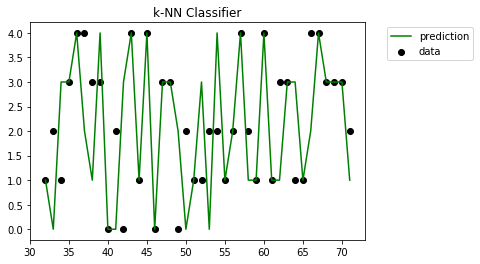

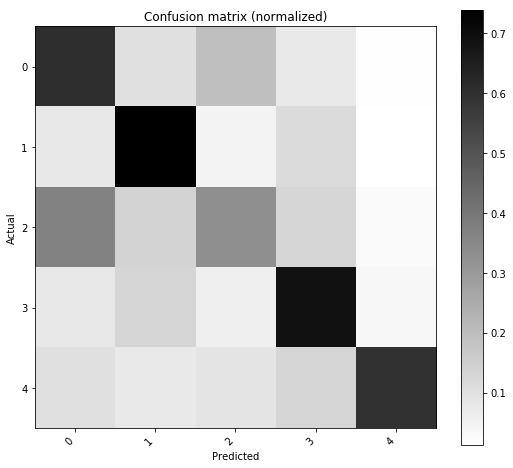

In [9]:
from pandas_ml import ConfusionMatrix

knn = df.neighbors.KNeighborsClassifier(n_neighbors=18)     #choose k-NN classifier with k=18

X_train.fit(knn)                #train the model with training set
preds = X_test.predict(knn)     #make predictions on test set

#################### Compute Accuracy ##################
correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1            #if the current prediction is correct, then increment the "correct" counter

acc = correct/len(preds)*100    #compute overall accuracy

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

#################### Plot some predictions ##################
plt.figure()
n_points = 40
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("k-NN Classifier")
plt.show()

#################### Plot Confusion Matrix ##################
%matplotlib inline
conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 2) Logistic Classifier

Predicted correctly: 21653/48165
Accuracy (%): 44.9559


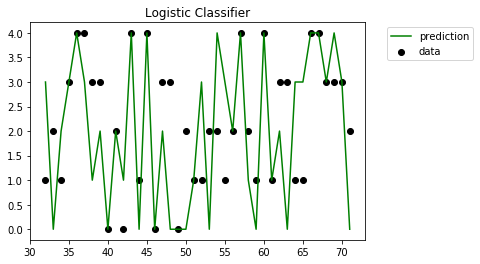

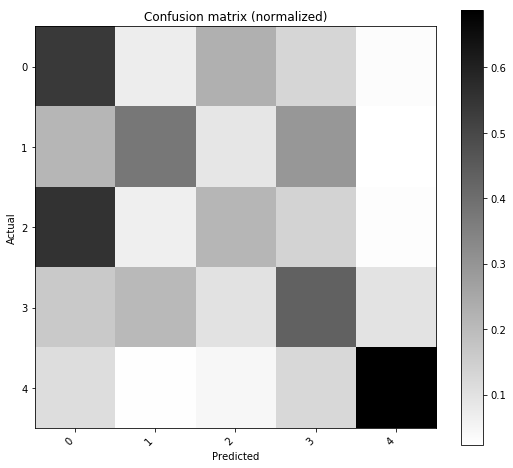

In [11]:
from pandas_ml import ConfusionMatrix

log = df.linear_model.LogisticRegression(fit_intercept=True, random_state=0)     #choose Logistic classifier

X_train.fit(log)                #train the model with training set
preds = X_test.predict(log)     #make predictions on test set

#################### Compute Accuracy ##################
correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1            #if the current prediction is correct, then increment the "correct" counter

acc = correct/len(preds)*100    #compute overall accuracy

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

#################### Plot some predictions ##################
plt.figure()
n_points = 40
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Logistic Classifier")
plt.show()

#################### Plot Confusion Matrix ##################
%matplotlib inline
conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 3) Support Vector Machine

Predicted correctly: 30568/48165
Accuracy (%): 63.4652


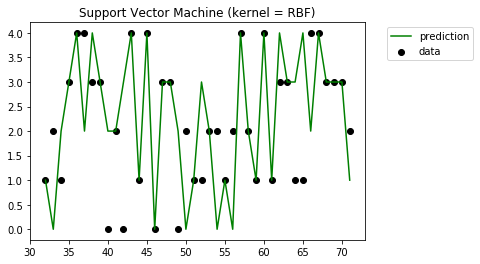

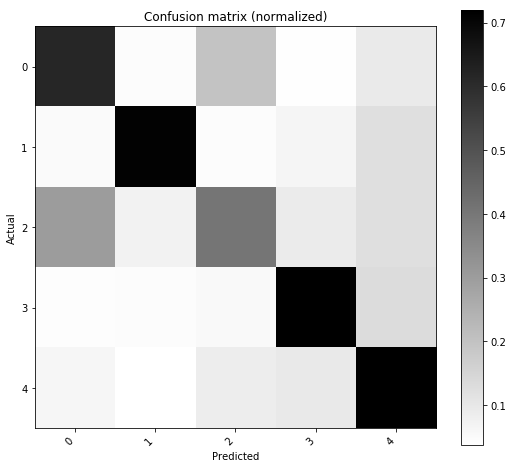

In [12]:
#Support Vector Machine with C=1, Radial Basis function as kernel
svc = df.svm.SVC(C=1.0, kernel='rbf', gamma='auto', random_state=0)

X_train.fit(svc)                #train the model with training set
preds = X_test.predict(svc)     #make predictions on test set

#################### Compute Accuracy ##################
correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1            #if the current prediction is correct, then increment the "correct" counter

acc = correct/len(preds)*100    #compute overall accuracy

8' 
print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

#################### Plot some predictions ##################
plt.figure()
n_points = 40
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Support Vector Machine (kernel = RBF)")
plt.show()

#################### Plot Confusion Matrix ##################
%matplotlib inline
conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 4) Decision Tree

Predicted correctly: 30226/48165
Accuracy (%): 62.7551


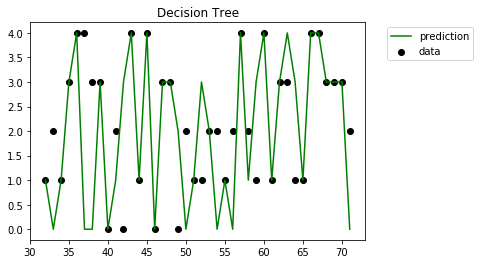

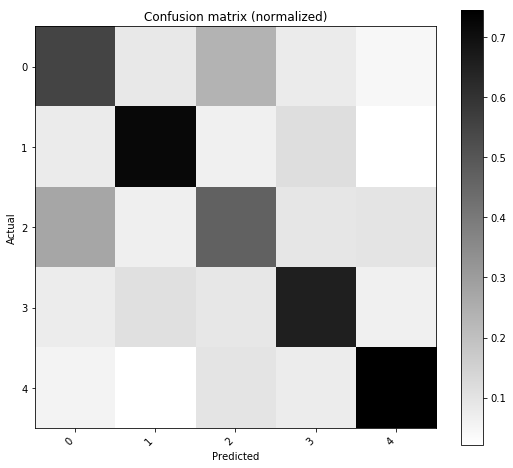

In [17]:
dt = df.tree.DecisionTreeClassifier(random_state=0)

X_train.fit(dt)                #train the model with training set
preds = X_test.predict(dt)     #make predictions on test set

#################### Compute Accuracy ##################
correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1            #if the current prediction is correct, then increment the "correct" counter

acc = correct/len(preds)*100    #compute overall accuracy


print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

#################### Plot some predictions ##################
plt.figure()
n_points = 40
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Decision Tree")
plt.show()

#################### Plot Confusion Matrix ##################
%matplotlib inline
conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 5) Neural Network

Predicted correctly: 16691/48165
Accuracy (%): 34.6538


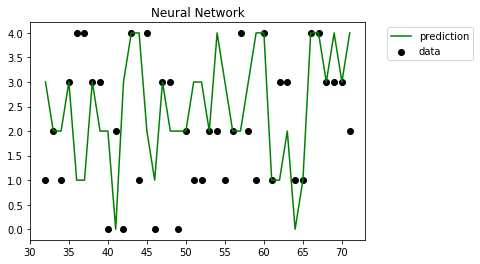

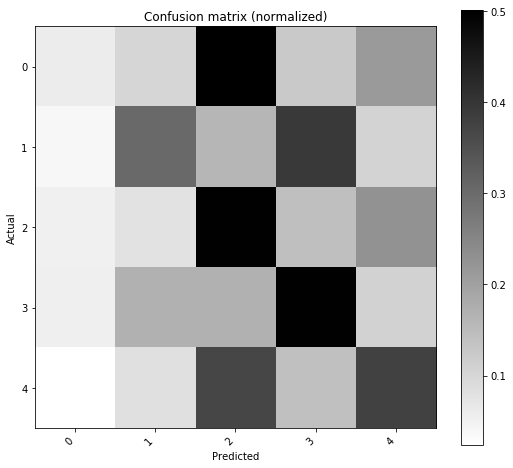

In [21]:
net = df.neural_network.MLPClassifier(solver='lbfgs', activation = 'tanh',
                                        alpha = 0.1,
                                        hidden_layer_sizes = [100, 100],
                                        random_state = 0)

X_train.fit(net)                #train the model with training set
preds = X_test.predict(net)     #make predictions on test set

#################### Compute Accuracy ##################
correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1            #if the current prediction is correct, then increment the "correct" counter

acc = correct/len(preds)*100    #compute overall accuracy


print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

#################### Plot some predictions ##################
plt.figure()
n_points = 40
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Neural Network")
plt.show()

#################### Plot Confusion Matrix ##################
%matplotlib inline
conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 6) XGBoost (GBDT)

In [6]:
import xgboost as xgb

params = {
    'eta': 1,                    # learning rate
    'num_class': 5,                      # number of classes
      'max_depth': 20,                    # maximum depth of a tree
      'subsample': 1,                  # subsample ratio of the training instances to grow trees and prevent overfitting.
      'colsample_bytree': 1,             # subsample ratio of columns when constructing each tree
      'objective': 'multi:softmax',      # Specify the learning task and the corresponding learning objective
      'eval_metric': 'merror',           # evaluation metrics
      'seed': 2018,                      # random number seed
      'silent': False                   # 0 means printing running messages, 1 means silent mode.
}

bst = df.xgboost.XGBClassifier(**params)
#bst = XGBClassifier(**params).fit(X_train, y_train)

X_train.fit(bst)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=5, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=False, subsample=1)

#### Accuracy

In [33]:
preds = X_test_ns.predict(bst)
#preds = bst.predict(X_test)

correct=0
for i in range(len(preds)):
    if(X_test_ns.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

X_test_ns.metrics.confusion_matrix()

Predicted correctly: 18212/23867
Accuracy (%): 76.3062


Predicted,0,1,2,3,4
Target,,,,,
0,2305,39,1159,68,39
1,35,538,133,50,35
2,1161,110,6205,432,142
3,61,25,201,1489,84
4,338,60,962,521,7675


In [31]:
X_test_ns.shape

(23867, 8)

### Plot

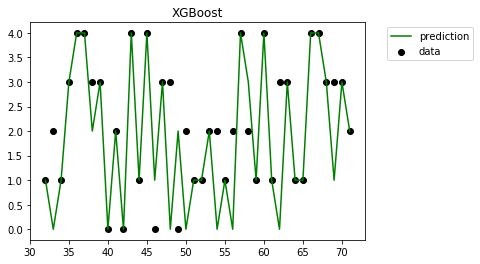

In [25]:
import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 40
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("XGBoost")
plt.show()

#### Confusion Matrix

Confusion Matrix:

Predicted     0      1      2      3     4  __all__
Actual                                             
0          5748    739   2540    551   114     9692
1           512   7989    405    693    94     9693
2          2455    489   5468    880   267     9559
3           447    915    613   7418   321     9714
4           416    127   1155    848  6961     9507
__all__    9578  10259  10181  10390  7757    48165


Overall Statistics:

Accuracy: 0.697269801723
95% CI: (0.69314453474347226, 0.70137128144047167)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.621527815569
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1         2  \
Population                                 48165      48165     48165   
P: Condition positive                       9692       9693      9559   
N: Condition negative                      38473      38472     38606   
Test outcome positive                       9578   

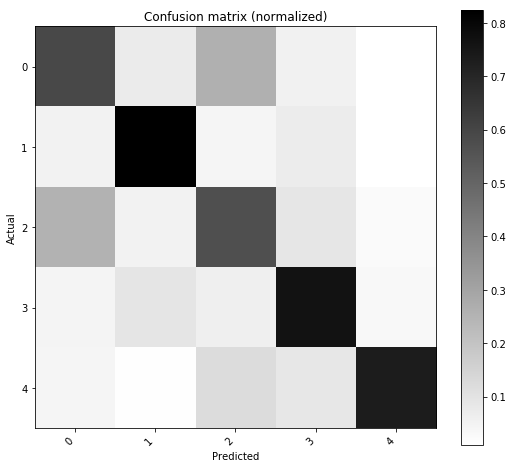

In [15]:
import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)
conf_matrix.print_stats()

#### Precision-Recall Curve

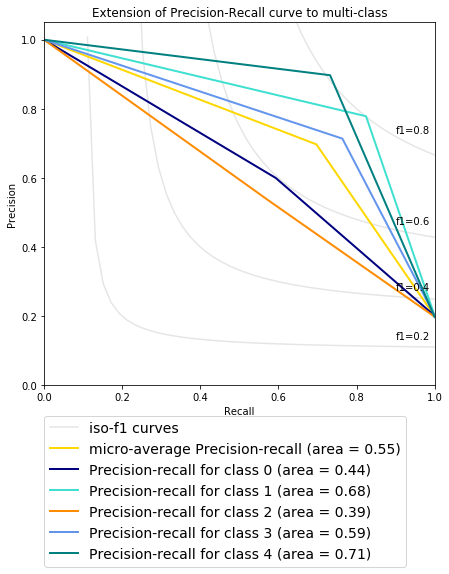

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Use label_binarize to be multi-label like settings
Y = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
Y_p = label_binarize(preds, classes=[0, 1, 2, 3, 4])
n_classes = Y.shape[1]

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i], Y_p[:, i])
    average_precision[i] = average_precision_score(Y[:, i], Y_p[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), Y_p.ravel())
average_precision["micro"] = average_precision_score(Y, Y_p, average="micro")

# Plot
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    a = np.linspace(0.01, 1)
    b = f_score * a / (2 * a - f_score)
    l, = plt.plot(a[b >= 0], b[b >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, b[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.5), prop=dict(size=14))
plt.show()

#### Feature Importance

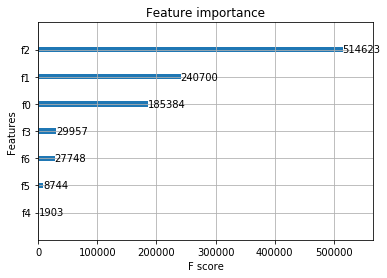

In [17]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(bst)
plt.show()

### Learning Curve

In [20]:
from sklearn.learning_curve import learning_curve

X_test.model_selection.learning_curve(bst)

(array([ 3210, 10435, 17659, 24884, 32109]),
 array([[ 0.98691589,  0.98909657,  0.98909657],
        [ 0.96415908,  0.96233828,  0.96233828],
        [ 0.95016705,  0.95033694,  0.95203579],
        [ 0.94108664,  0.94333708,  0.94044366],
        [ 0.93272914,  0.93459778,  0.93219969]]),
 array([[ 0.50666418,  0.50401744,  0.50741248],
        [ 0.55842053,  0.55278729,  0.55711972],
        [ 0.58314649,  0.57770165,  0.58016694],
        [ 0.60220478,  0.59296169,  0.59312321],
        [ 0.61266816,  0.60828402,  0.61480005]]))